# Deep Learning for Object Detection of LEGO Pieces



In [ ]:
# Import necessary libraries for dataset handling
from sklearn.model_selection import train_test_split

In [ ]:
### Your code goes here.
from google.colab import files
files.upload()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dreamfactor/biggest-lego-dataset-600-parts")

print("Path to dataset files:", path)

100%|██████████| 7.68G/7.68G [06:23<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dreamfactor/biggest-lego-dataset-600-parts/versions/1


In [ ]:
import os

# Path to the directory you want to create
output_image_dir = "/content/lego_dataset/limited_images"
output_annotation_dir = "/content/lego_dataset/limited_annotations"

# Create the directory
os.makedirs(output_image_dir, exist_ok=True)  # `exist_ok=True` prevents errors if the directory already exists

print(f"Directory '{output_image_dir}' created!")

os.makedirs(output_annotation_dir, exist_ok=True)  # `exist_ok=True` prevents errors if the directory already exists

print(f"Directory '{output_annotation_dir}' created!")


Directory '/content/lego_dataset/limited_images' created!
Directory '/content/lego_dataset/limited_annotations' created!


In [ ]:
import os
import shutil

# Define paths
image_dir = '/root/.cache/kagglehub/datasets/dreamfactor/biggest-lego-dataset-600-parts/versions/1/dataset_20210629145407_top_600/images/'
annotation_dir = '/root/.cache/kagglehub/datasets/dreamfactor/biggest-lego-dataset-600-parts/versions/1/dataset_20210629145407_top_600/annotations/'
output_image_dir = "/content/lego_dataset/limited_images"
output_annotation_dir = "/content/lego_dataset/limited_annotations"

# Create output directories for limited data
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_annotation_dir, exist_ok=True)

# Get sorted lists of image and annotation files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
annotation_files = sorted([f for f in os.listdir(annotation_dir) if f.endswith(".xml")])

# Create a mapping of images to annotations based on filename
image_base_names = {os.path.splitext(img)[0]: img for img in image_files}
annotation_base_names = {os.path.splitext(ann)[0]: ann for ann in annotation_files}

# Find common base names to ensure proper matching
common_base_names = set(image_base_names.keys()).intersection(annotation_base_names.keys())

# Limit to 10,000 images and corresponding annotations
for base_name in sorted(common_base_names)[:10000]:
    img_file = image_base_names[base_name]
    ann_file = annotation_base_names[base_name]

    shutil.copy(os.path.join(image_dir, img_file), output_image_dir)
    shutil.copy(os.path.join(annotation_dir, ann_file), output_annotation_dir)

print(f"Limited dataset created with 10000 images and their corresponding annotations!")


Limited dataset created with 50000 images and their corresponding annotations!


In [ ]:
output_image_dir = "/content/lego_dataset/limited_images"
output_annotation_dir = "/content/lego_dataset/limited_annotations"

image_filess = [f for f in os.listdir(output_image_dir) if f.endswith(".jpg")]
annotation_filess = [f for f in os.listdir(output_annotation_dir) if f.endswith(".xml")]

# Print lengths
print(f"Number of images: {len(image_filess)}")
print(f"Number of annotations: {len(annotation_filess)}")


Number of images: 10000
Number of annotations: 10000


In [ ]:
from torch.utils.data import Dataset # Import the Dataset class from torch.utils.data

import xml.etree.ElementTree as ET # Import the ElementTree for parsing XML
from PIL import Image
import torch
from torchvision import transforms
class LEGOImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            annotation_dir (str): Path to the directory containing annotations.
            transforms (callable, optional): Optional transforms for the images.
        """
        self.image_dir = image_dir # Intializing the directory for images
        self.annotation_dir = annotation_dir # Intializing directory for annotation
        self.transforms = transforms # Intializing tranforms which use to tranforms images


        # Initialize the map for non-numeric labels
        self.non_numeric_label_map = {}
        self.next_non_numeric_id = 1000  # Starting ID for non-numeric labels

        # Ensure that the number of images matches the number of annotations
        assert len(self.image_files) == len(self.annotation_files), "Mismatch between images and annotations."

    def __getitem__(self, idx):
        # Get the paths for the current image and annotation
        image_path = self.image_files[idx]
        annotation_path = self.annotation_files[idx]

        # Load the image
        image = Image.open(image_path).convert("RGB")
        original_width, original_height = image.size  # Get original image dimensions

        # Parse the annotation
        boxes, labels = self.parse_annotation(annotation_path)

        # Adjust bounding boxes based on new image dimensions
        if self.transforms:
            # Apply transformations and get new dimensions
            transformed = self.transforms(image)
            new_width, new_height = transformed.size
        else:
            # resize to 300x300 and convert to tensor
            new_width, new_height = 300, 300
            transform = transforms.Compose(
                [
                    transforms.Resize((new_height, new_width)),
                    transforms.ToTensor(),
                ]
            )
            transformed = transform(image)

        # Scale boxes to match the new image size
        scale_x = new_width / original_width  # Scale factor for the width
        scale_y = new_height / original_height # Scale factor for the height

        # Scale each coordinate of the bounding box to match the new dimension
        adjusted_boxes = [
            [box[0] * scale_x, box[1] * scale_y, box[2] * scale_x, box[3] * scale_y] for box in boxes
        ]

        # Create the target dictionary
        target = {
            "boxes": torch.tensor(adjusted_boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        return transformed, target

    def __len__(self):
        return len(self.image_files)

    def parse_annotation(self, annotation_path):
        """
        Parse the annotation XML file and return bounding boxes and numerical labels.
        """

        # Parse the XML file at the specified annotation path
        tree = ET.parse(annotation_path)

        # Get the root element of the parsed XML tree
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"): # Iterate through all "object" elements in the XML tree
            label = obj.find("name").text  # Find the "name" element within the current "object" and extract its text content



            # Parse bounding box
            bndbox = obj.find("bndbox")
            x1 = int(bndbox.find("xmin").text) # Top-left x-coordinate
            y1 = int(bndbox.find("ymin").text) # Top-left y-coordinate
            x2 = int(bndbox.find("xmax").text) # Bottom-right x-coordinate
            y2 = int(bndbox.find("ymax").text) # Bottom-right y-coordinate

            boxes.append([x1, y1, x2, y2])
            labels.append(label_int)

        if len(boxes) == 0:
            print(f"No valid objects in file '{annotation_path}'. Returning empty boxes and labels.")

        return boxes, labels



In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Assume `dataset` is your dataset and `labels` contains the corresponding labels
# Extract labels for stratification
dataset = LEGOImageDataset(output_image_dir, output_annotation_dir)
labels = [item[1]["labels"][0].item() for item in dataset]  # Extract the first label from each target

# Count the occurrences of each label
label_counts = Counter(labels)

# Oversample single-instance classes
oversampled_dataset = []
oversampled_labels = []

for item, label in zip(dataset, labels): # Iterate through each item in the dataset along with its corresponding label
    oversampled_dataset.append(item)
    oversampled_labels.append(label)
    # Check if the current label has only one instance in the dataset
    if label_counts[label] == 1:
        # If it's a single-instance label, duplicate the item to balance the dataset
        oversampled_dataset.append(item)
        oversampled_labels.append(label)

# Stage 1: Split into train (70%) and temp (30%)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    oversampled_dataset, oversampled_labels, test_size=0.3, stratify=oversampled_labels, random_state=42
)

# Stage 2: Split temp into validation (15%) and test (15%)
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)




Assigned new ID 1000 to non-numeric label '3829c01'.
Assigned new ID 1000 to non-numeric label '3829c01'.
Assigned new ID 1001 to non-numeric label '2412b'.
Assigned new ID 1002 to non-numeric label '6126b'.
Assigned new ID 1000 to non-numeric label '3829c01'.
Assigned new ID 1003 to non-numeric label '3942c'.
Assigned new ID 1004 to non-numeric label '3070b'.
Assigned new ID 1001 to non-numeric label '2412b'.
Assigned new ID 1005 to non-numeric label '3839b'.
Assigned new ID 1001 to non-numeric label '2412b'.
Assigned new ID 1006 to non-numeric label '3678b'.
Assigned new ID 1007 to non-numeric label '30350b'.
Assigned new ID 1001 to non-numeric label '2412b'.
Assigned new ID 1004 to non-numeric label '3070b'.
Assigned new ID 1008 to non-numeric label '3709b'.
Assigned new ID 1009 to non-numeric label '4265c'.
Assigned new ID 1010 to non-numeric label '3069b'.
Assigned new ID 1011 to non-numeric label '3684c'.
Assigned new ID 1008 to non-numeric label '3709b'.
Assigned new ID 1002 to 

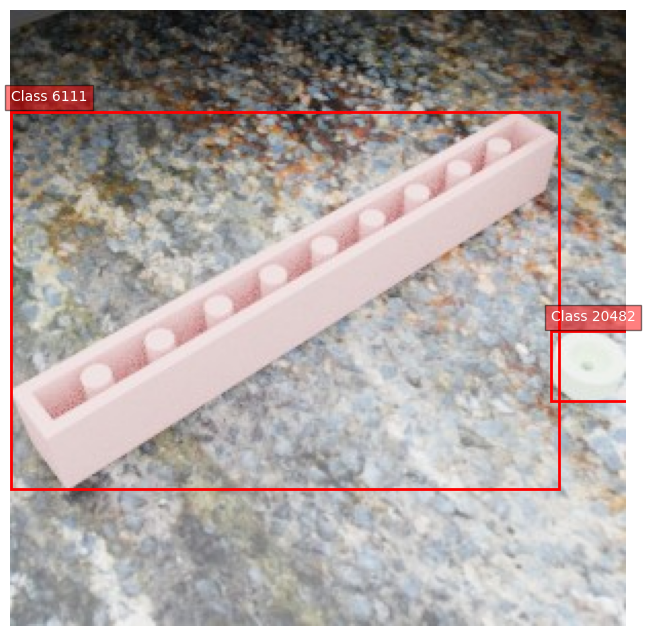

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, target):
    """
    Plot an image with bounding boxes and class labels.

    Args:
        image: The image tensor (C, H, W).
        target: A dictionary containing:
            - 'boxes': Tensor of bounding boxes [x1, y1, x2, y2].
            - 'labels': Tensor of class labels.
    """
    # Convert image tensor to numpy array for visualization
    image = image.permute(1, 2, 0).numpy()

    # Create the plot
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Plot bounding boxes
    boxes = target["boxes"]
    labels = target["labels"]

    for box, label in zip(boxes, labels):
      # Extract the coordinates of the bounding box and convert them to a list
        x1, y1, x2, y2 = box.tolist()
        # Calculate the width and height of the bounding box
        width, height = x2 - x1, y2 - y1

        # Draw the rectangle
        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

        # Add class label
        ax.text(
            x1, y1 - 5, f"Class {label.item()}", color="white", fontsize=10, bbox=dict(facecolor="red", alpha=0.5)
        )

    # Hide axes and show the plot
    ax.axis("off")
    plt.show()

# Plot the first image with annotations from the training set
image, target = train_data[0]  # Get the first sample from train_images
plot_image_with_boxes(image, target)

In [ ]:
def find_highest_label(dataset):
    """
    Find the highest label in the dataset.

    Args:
        dataset (LEGOImageDataset): The dataset instance.

    Returns:
        int: The highest label in the dataset.
    """
    highest_label = -float('inf')  # Initialize to a very low value

    for idx in range(len(dataset)):
        _, target = dataset[idx]  # Get the target dictionary for the current sample
        labels = target['labels']  # Extract the labels
        max_label = labels.max().item()  # Find the max label in the current sample
        highest_label = max(highest_label, max_label)  # Update the highest label found

    return highest_label


# Assuming `train_dataset` is an instance of LEGOImageDataset
highest_label = find_highest_label(train_images)
print(f"The highest label in the dataset is: {highest_label}")


The highest label in the dataset is: 99781


This funtion is used to find the higest number of class label for the model.

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Define the model (using a pre-trained Faster R-CNN model from torchvision)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the head with one that matches our dataset
num_classes = 99782  # Adjust this number based on your dataset (1 for LEGO pieces + 1 for background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move the model to the GPU
model.to(device)

# Custom collation function
def collate_fn(batch):
    """
    Custom collation function to handle batches with images of varying sizes.
    """
    images, targets = zip(*batch)
    return list(images), list(targets)

# Define the DataLoader
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Set the model to training mode and define optimizer
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005) # Seting model parameter like learning rate 0.001.
num_epochs = 6
# Training loop with tqdm
for epoch in range(num_epochs):
    epoch_loss = 0.0 # Set 0 for epoch in each iterations
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1} /{num_epochs}]") # tdqm progress bar

    for images, targets in progress_bar: # Sperating images and tragets for each iteration
        images = [image.to(device) for image in images] # This code ensure that, list of images moved to the same gpu or cpu. In this case it gpu
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]# Repeating the same process done for images to targets

        optimizer.zero_grad() # It ensure that the gradient set to zero at each iterations
        loss_dict = model(images, targets) # Feeding images and traget to the model
        losses = sum(loss for loss in loss_dict.values()) # Calculating the losse and sotred the sum of lose in varible called losses
        losses.backward() # Calculating gradient of loss, which enable the model to adjuest the parameters
        optimizer.step() # Learning

        # Update epoch loss and progress bar
        epoch_loss += losses.item() # Calculating all the losses for each epoch
        progress_bar.set_postfix(loss=losses.item()) #updating the progress bar

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}") #print total epochs


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 151MB/s]
Epoch [1 /6]: 100%|██████████| 1750/1750 [29:59<00:00,  1.03s/it, loss=1.18]


Epoch [1/6], Total Loss: 3728.6641


Epoch [2 /6]: 100%|██████████| 1750/1750 [30:03<00:00,  1.03s/it, loss=1.13]


Epoch [2/6], Total Loss: 2367.7418


Epoch [3 /6]: 100%|██████████| 1750/1750 [30:00<00:00,  1.03s/it, loss=0.843]


Epoch [3/6], Total Loss: 1766.7208


Epoch [4 /6]: 100%|██████████| 1750/1750 [29:59<00:00,  1.03s/it, loss=0.684]


Epoch [4/6], Total Loss: 1445.7719


Epoch [5 /6]: 100%|██████████| 1750/1750 [29:58<00:00,  1.03s/it, loss=0.807]


Epoch [5/6], Total Loss: 1236.7267


Epoch [6 /6]: 100%|██████████| 1750/1750 [29:58<00:00,  1.03s/it, loss=0.625]

Epoch [6/6], Total Loss: 1078.9205


**Code Documentation **

I'm using the R CNN to train the dataset. The R CNN take to much time to run therfore, I siwch from CPU to GPU for faster excuation

```
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}").
```

Followed by calling the model. In this case it is already write, it use R CNN model wich trained on resnet50. After that, defing the numer of classes, to find the total numbers of class I have use find_highest_label function and the result was 99781 + 1 99782. Followed by geting the features and classifier.


```
def collate_fn(batch):
    """
    Custom collation function to handle batches with images of varying sizes.
    """
    images, targets = zip(*batch)
    return list(images), list(targets)
```

While,training the model I got errors which were associated with size of the image. Eventhough, I did the transformation in getitiem function before spliting the data the code giving error. To over come this problem, I define collate fn to unzip the images and targets to train.


```
train_loader = DataLoader(train_images, batch_size=4, shuffle=True, collate_fn=collate_fn)
```

Calling the data loader for the tran_images data set with batch size 4 (4 group of data sample for the train) along with collate_fn and sotred in a varible called train_loader.


```
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 2

```

Intinalizing the model with learin rate set to 0.005 and weigh_decay 0.0005. number of epochs to 2


```
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1} /{num_epochs}]")
```

I put a progress bar with help of tdqm library.



```
    for images, targets in progress_bar:
        # Move images and targets to the GPU
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
```

The for loop iterate over the epochs and set epoch equall to 0 at the beging of the each iterations. Followed by a progress bar. In the inner loop it sperate images and traget train_loader tranfer the calculation to GPU over CPU.

```
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        # Update epoch loss and progress bar
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}")
```

Set the gradients for all model parameter to avoid accumalation from the pervious steps. Followed by forward pass then compute the losses after that a backward pass to compute the gradients. Finally, updating the model parametere.

```
        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}")
```

In these step, it track the epoch loss and update the progress bar.


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# Assuming test_images is your test dataset
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Function to make predictions
def make_predictions(model, data_loader, device):
    model.eval() # Set the model for evaluation
    predictions = []
    with torch.no_grad(): # Disable gradient computation for inference
        for images, _ in tqdm(data_loader, desc="Making predictions"): # Iterate through the data loader with a progress bar
            images = [image.to(device) for image in images]# Move images to the GPU
            outputs = model(images) # Pass images through the model to get outputs
            predictions.extend(outputs) # Append the outputs to the predictions list
            torch.cuda.empty_cache()  # Free unused memory after each batch
    return predictions

# Make predictions on the test set
predictions = make_predictions(model, test_loader, device)

Making predictions: 100%|██████████| 1500/1500 [11:14<00:00,  2.22it/s]


In [ ]:
from tqdm import tqdm
from collections import defaultdict


# Function to calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute intersection area
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    return inter_area / union_area

# Evaluate predictions against ground truths
def evaluate_predictions(predictions, data_loader, iou_threshold=0.5):
    """
    Evaluate model predictions and compute precision, recall, and mAP.
    """
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    all_iou_scores = []

    # Extract ground truths from the dataset
    ground_truths = []
    for _, targets in data_loader:
        ground_truths.extend(targets) # Adding targets to the list

    for pred, gt in zip(predictions, ground_truths): # Loop through predictions and corresponding ground truths
        # Extracting boxes,scores,labels from the perdiction
        pred_boxes = pred["boxes"].cpu().numpy()
        pred_scores = pred["scores"].cpu().numpy()  # Prediction confidence scores
        pred_labels = pred["labels"].cpu().numpy()
        # Extracting the ground truth details
        gt_boxes = gt["boxes"].cpu().numpy()
        gt_labels = gt["labels"].cpu().numpy()

        # Match predicted boxes to ground truth boxes using IoU
        matched_gt = set()
        for i, pred_box in enumerate(pred_boxes):
            max_iou = 0
            max_j = -1
            for j, gt_box in enumerate(gt_boxes):
                if gt_labels[j] != pred_labels[i] or j in matched_gt: # Skip if ground truth box is already matched
                    continue
                iou = calculate_iou(pred_box, gt_box) # Calculate iou for the predicted and ground truth boxes
                # Update max iou and best matching box
                if iou > max_iou:
                    max_iou = iou
                    max_j = j
            # Comparing with threshold values, if it higher than threshold vale then it will consider as true positve
            if max_iou >= iou_threshold:
                tp += 1
                matched_gt.add(max_j)
                all_iou_scores.append(max_iou)
            else:
                fp += 1

        # Remaining ground truths are false negatives
        fn += len(gt_boxes) - len(matched_gt)

    # Compute precision, recall, and mAP
    precision = tp / (tp + fp) if tp + fp > 0 else 0 # calculating precision
    recall = tp / (tp + fn) if tp + fn > 0 else 0 # Calculating recall
    mAP = np.mean(all_iou_scores) if all_iou_scores else 0 # Calculating mAP

    return {"precision": precision, "recall": recall, "mAP": mAP}

# Calculate metrics
metrics = evaluate_predictions(predictions, test_loader)
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"mAP: {metrics['mAP']:.4f}")

Precision: 0.1066
Recall: 0.8020
mAP: 0.8341


In [ ]:
# Save the trained model to a file
model_file = 'fasterrcnn_model_11.pth'
torch.save(model.state_dict(), model_file)
print(f"Model saved to {model_file}")


# Load the saved model for inference
loaded_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
loaded_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
loaded_model.load_state_dict(torch.load(model_file))
loaded_model.eval()
print("Model loaded for inference.")

Model saved to fasterrcnn_model_11.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.7MB/s]
<ipython-input-17-0d5c6ffd4c44>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

Model loaded for inference.


Boxes: [[  1.1825867  46.239567  275.29257   267.9592   ]
 [  0.         49.018696  292.76685   274.22742  ]
 [  0.         33.861958  283.9005    275.79297  ]]
Scores: [0.10533778 0.07784837 0.07290544]


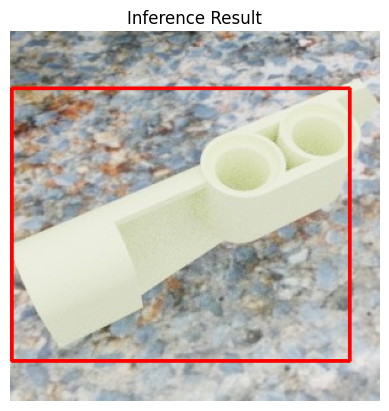

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
def run_inference(image_path):
    # Load the image
    image = cv.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Convert the image to a tensor
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0)

    # Run the model on the image
    model.eval()  # model is in evaluation mode
    with torch.no_grad():
        predictions = model(image_tensor.to(device))

    # Extract bounding boxes and scores
    if len(predictions) > 0:
        boxes = predictions[0].get('boxes', []).cpu().numpy()
        scores = predictions[0].get('scores', []).cpu().numpy()
        print(f"Boxes: {boxes}")
        print(f"Scores: {scores}")

        # Draw bounding boxes with a lower threshold
        for box, score in zip(boxes, scores):
            if score > 0.09:  # Confidence threshold adjusted
                x1, y1, x2, y2 = box
                cv.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # Display the image
    plt.imshow(image_rgb)
    plt.title("Inference Result")
    plt.axis('off')
    plt.show()

# Test with a sample image
run_inference('/root/.cache/kagglehub/datasets/dreamfactor/biggest-lego-dataset-600-parts/versions/1/dataset_20210629145407_top_600/images/3ea0ed86-e5e4-11eb-ad05-b0c090bd3910.jpg')
